<a href="https://colab.research.google.com/github/aviMitra/EVA5/blob/main/Assignment%205/CODE_3_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Target:


*   The no. of parameters should be in range (less than 10K).
*   Uses Image augmentation and Learning Rate Decay (On Plateau) in addition to the previous model.
*   Get an accuracy more than 99.4% on at least last 4 epochs

##Results:

*   Parameters: 8.8K
*   Best Train Accuracy: 99.15
*   Best Test Accuracy: 99.48

##Analysis:

*   It is a fantastic model. The test Accuracy is higher than Training Accuracy, so we haven't seen overfitting yet
*   The model has reached the target in last 6 epochs



# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop = 0.05
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=13, kernel_size=(1, 1), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(13),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(13),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 5

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.Dropout(self.drop),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [20]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
           Dropout-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
           Dropout-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
              ReLU-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,080
          Dropout-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [27]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    description = 'Loss={:.4f} Batch_id={} Accuracy={:.2f}'.format(loss.item(), batch_idx, 100*correct/processed)
    train_acc.append(100*correct/processed)
  print(description)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

# Let's Train and test our model

In [29]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print('Learning rate: ', optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    loss = test(model, device, test_loader)
    scheduler.step(loss)

EPOCH: 0
Learning rate:  0.1
Loss=0.0427 Batch_id=468 Accuracy=95.05

Test set: Average loss: 0.0626, Accuracy: 9811/10000 (98.11%)

EPOCH: 1
Learning rate:  0.1
Loss=0.0118 Batch_id=468 Accuracy=97.85

Test set: Average loss: 0.0421, Accuracy: 9865/10000 (98.65%)

EPOCH: 2
Learning rate:  0.1
Loss=0.0269 Batch_id=468 Accuracy=98.09

Test set: Average loss: 0.0288, Accuracy: 9906/10000 (99.06%)

EPOCH: 3
Learning rate:  0.1
Loss=0.0217 Batch_id=468 Accuracy=98.33

Test set: Average loss: 0.0296, Accuracy: 9901/10000 (99.01%)

EPOCH: 4
Learning rate:  0.1
Loss=0.0680 Batch_id=468 Accuracy=98.52

Test set: Average loss: 0.0248, Accuracy: 9908/10000 (99.08%)

EPOCH: 5
Learning rate:  0.1
Loss=0.0055 Batch_id=468 Accuracy=98.60

Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99.08%)

EPOCH: 6
Learning rate:  0.1
Loss=0.0146 Batch_id=468 Accuracy=98.64

Test set: Average loss: 0.0230, Accuracy: 9920/10000 (99.20%)

EPOCH: 7
Learning rate:  0.1
Loss=0.0170 Batch_id=468 Accuracy=98.67


Text(0.5, 1.0, 'Test Accuracy')

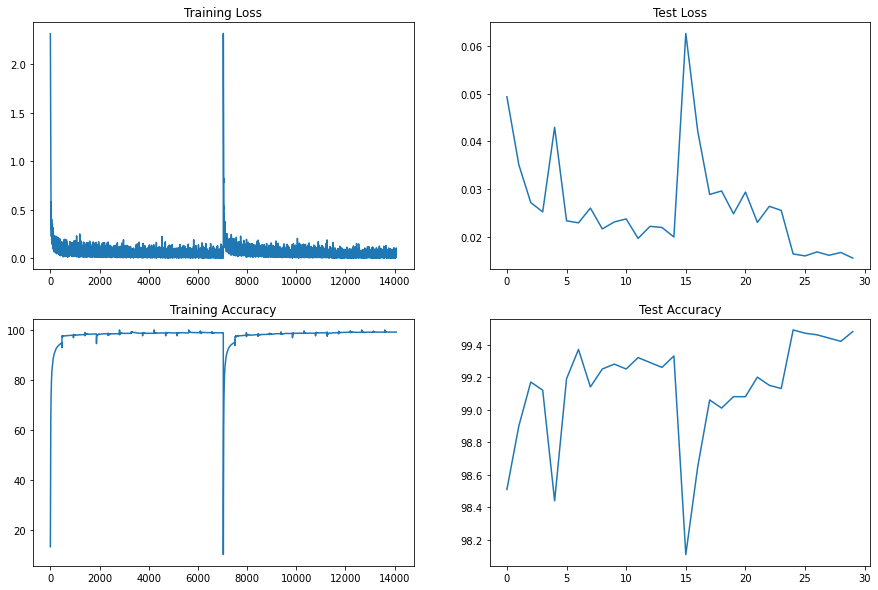

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")